In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import os

In [2]:
import pandas as pd
import glob
import os

# Path to your CSVs
path = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index/1.5Y-old-tokens/dataframes/*.csv"
csv_files = glob.glob(path)

print(f"Found {len(csv_files)} CSV files.\n")

# Print filename and number of rows
for file in csv_files:
    try:
        df = pd.read_csv(file)
        token = os.path.basename(file).replace(".csv", "")
        print(f"{token}: {df.shape[0]} rows")
    except Exception as e:
        print(f"Failed to read {file}: {e}")


Found 9 CSV files.

KEKEC: 364 rows
JOE: 375 rows
BCAT: 369 rows
LMI: 347 rows
EMP: 360 rows
TITANX: 353 rows
ZYN: 368 rows
SATOSHI: 372 rows
SPECTRE: 360 rows


### From Day-1 to Day-30

In [3]:
# === Load and preprocess all CSV files ===
path = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index/1.5Y-old-tokens/dataframes/*.csv"
csv_files = glob.glob(path)

dfs = {}
for file in csv_files:
    token = os.path.basename(file).replace(".csv", "")
    df = pd.read_csv(file, parse_dates=["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)
    df = df[df["close"] > 0]  # Remove any rows with zero or invalid prices
    if len(df) >= 25:
        df = df.tail(25).copy()  # Keep only the last 25 rows
        df["token"] = token
        dfs[token] = df

# Ensure we have enough tokens
if len(dfs) < 2:
    raise ValueError("Not enough tokens with at least 25 days of data.")

# === Align on timestamp ===
merged = pd.concat(dfs.values())
pivot_close = merged.pivot(index="timestamp", columns="token", values="close")
pivot_volume = merged.pivot(index="timestamp", columns="token", values="volume")

# Keep only tokens with 25 valid entries (no NaNs)
valid_tokens = pivot_close.columns[pivot_close.notna().sum() == 25]
pivot_close = pivot_close[valid_tokens]
pivot_volume = pivot_volume[valid_tokens]

# Forward/backward fill just in case
pivot_close = pivot_close.ffill().bfill()
pivot_volume = pivot_volume.ffill().bfill()

# === Compute returns ===
returns_df = pivot_close.pct_change().dropna()
volumes_df = pivot_volume.loc[returns_df.index]

# === Portfolios ===
initial_capital = 1000

# Equal-weighted
equal_weights = np.repeat(1 / returns_df.shape[1], returns_df.shape[1])
eq_port_returns = returns_df.dot(equal_weights)
eq_cum_returns = (1 + eq_port_returns).cumprod()
eq_cum_returns_usd = eq_cum_returns * initial_capital

# Volume-weighted
initial_volumes = volumes_df.iloc[0]
vol_weights = initial_volumes / initial_volumes.sum()
vol_port_returns = returns_df.dot(vol_weights)
vol_cum_returns = (1 + vol_port_returns).cumprod()
vol_cum_returns_usd = vol_cum_returns * initial_capital

# === Performance metrics ===
def performance_metrics(port_returns, cum_returns_usd):
    final_value = cum_returns_usd.iloc[-1]
    sharpe = port_returns.mean() / port_returns.std() * np.sqrt(252) if port_returns.std() != 0 else np.nan
    max_dd = (1 - (1 + port_returns).cumprod() / (1 + port_returns).cumprod().cummax()).max()
    win_rate = (port_returns > 0).sum() / len(port_returns)
    expectancy = port_returns.mean() / -port_returns[port_returns < 0].mean() if (port_returns < 0).any() else np.nan
    return {
        "final_value_usd": final_value,
        "sharpe": sharpe,
        "max_drawdown": max_dd,
        "win_rate": win_rate,
        "expectancy": expectancy
    }

# === Results ===
print("=== Equal-Weighted Portfolio ===")
for k, v in performance_metrics(eq_port_returns, eq_cum_returns_usd).items():
    print(f"{k}: {v:.4f}")

print("\n=== Volume-Weighted Portfolio ===")
for k, v in performance_metrics(vol_port_returns, vol_cum_returns_usd).items():
    print(f"{k}: {v:.4f}")


=== Equal-Weighted Portfolio ===
final_value_usd: 2868.1641
sharpe: 4.0813
max_drawdown: 0.1426
win_rate: 0.5000
expectancy: 0.7454

=== Volume-Weighted Portfolio ===
final_value_usd: 2190.7920
sharpe: 3.1906
max_drawdown: 0.1559
win_rate: 0.4571
expectancy: 0.5840


In [4]:
# Calculate token-wise total returns (%)
token_returns = {}
for token, df in dfs.items():
    first_price = df["close"].iloc[0]
    last_price = df["close"].iloc[-1]
    total_return = (last_price - first_price) / first_price * 100
    token_returns[token] = total_return

# Convert to DataFrame for nicer display and sort descending
token_returns_df = pd.DataFrame(
    list(token_returns.items()), columns=["Token", "Total Return (%)"]
).sort_values(by="Total Return (%)", ascending=False).reset_index(drop=True)

print(token_returns_df)

     Token  Total Return (%)
0      JOE        245.828145
1      EMP        239.504546
2  SPECTRE        239.504546
3    KEKEC        115.184602
4  SATOSHI        102.757329
5   TITANX         78.560079
6      LMI         23.468326
7      ZYN         21.481003
8     BCAT         -9.250731


In [5]:
initial_capital = 1000
final_value_eq = eq_cum_returns_usd.iloc[-1]
final_value_vol = vol_cum_returns_usd.iloc[-1]

return_eq_pct = (final_value_eq / initial_capital - 1) * 100
return_vol_pct = (final_value_vol / initial_capital - 1) * 100

print(f"Equal-Weighted Portfolio Return: {return_eq_pct:.2f}%")
print(f"Volume-Weighted Portfolio Return: {return_vol_pct:.2f}%")

Equal-Weighted Portfolio Return: 186.82%
Volume-Weighted Portfolio Return: 119.08%


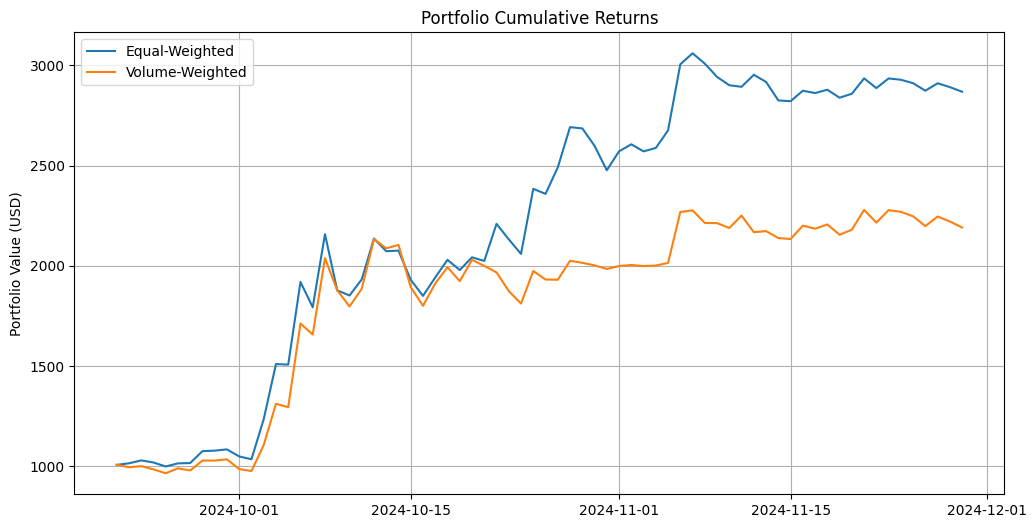

In [6]:
plt.figure(figsize=(12,6))
plt.plot(eq_cum_returns_usd, label='Equal-Weighted')
plt.plot(vol_cum_returns_usd, label='Volume-Weighted')
plt.ylabel("Portfolio Value (USD)")
plt.title("Portfolio Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()

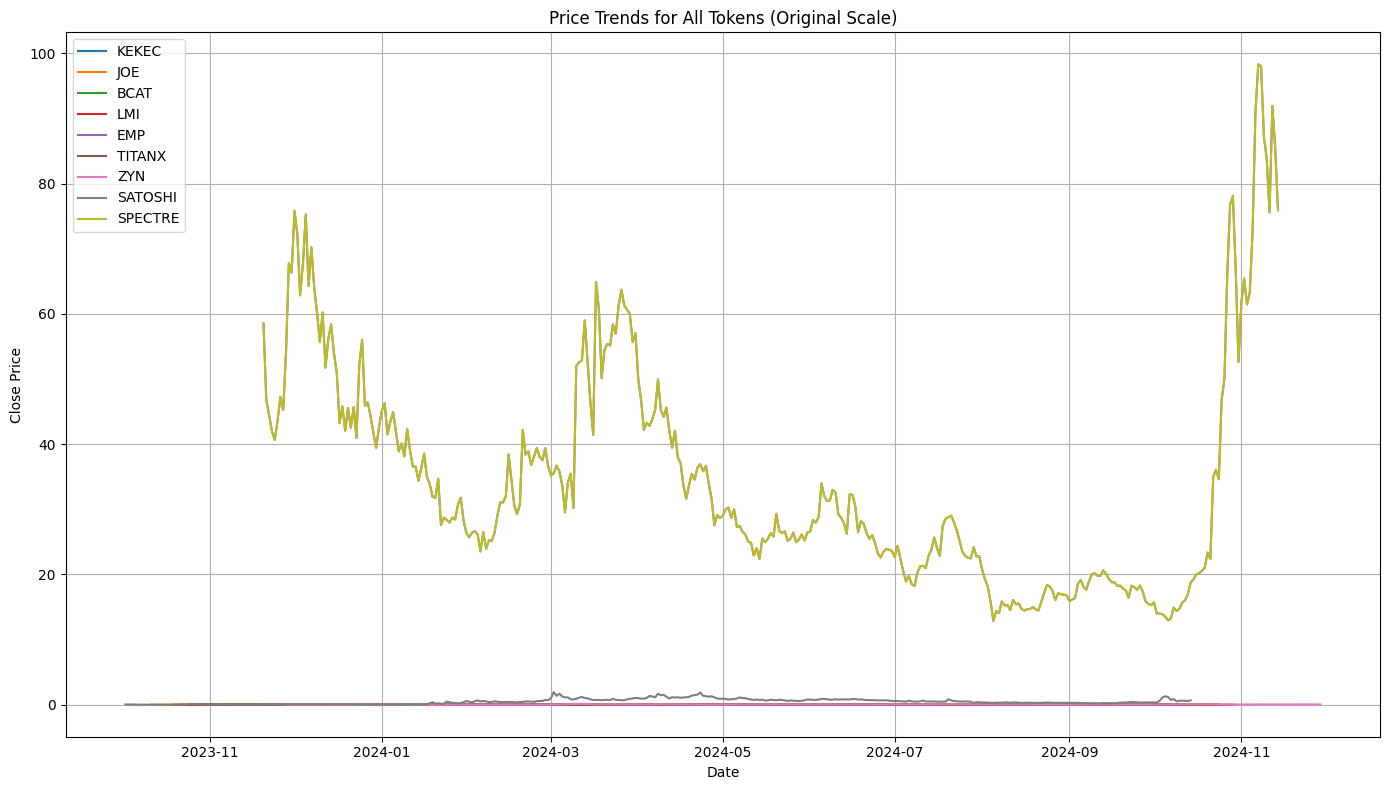

In [7]:
folder_path = './dataframes'
plt.figure(figsize=(14, 8))

for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        token_name = file.replace('.csv', '')
        df = pd.read_csv(os.path.join(folder_path, file), index_col=0, parse_dates=True)
        plt.plot(df.index, df['close'], label=token_name)

plt.title('Price Trends for All Tokens (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### From Day-1 to Day-180

In [8]:
# === Load and preprocess CSVs ===
path = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index/1.5Y-old-tokens/dataframes/*.csv"
csv_files = glob.glob(path)

dfs = {}
for file in csv_files:
    token = os.path.basename(file).replace(".csv", "")
    df = pd.read_csv(file, parse_dates=["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)
    df = df[df["close"] > 0]
    if len(df) >= 345:
        df = df.iloc[:345].copy()
        df["token"] = token
        dfs[token] = df

print(f"Found {len(dfs)} valid tokens: {list(dfs.keys())}")

# === Pivot data ===
merged = pd.concat(dfs.values())
pivot_close = merged.pivot(index="timestamp", columns="token", values="close")
pivot_volume = merged.pivot(index="timestamp", columns="token", values="volume")

# === Filter only tokens with full data ===
valid_tokens = pivot_close.columns[pivot_close.notna().sum() == 345]
pivot_close = pivot_close[valid_tokens]
pivot_volume = pivot_volume[valid_tokens]

# === Forward/backward fill ===
pivot_close = pivot_close.ffill().bfill()
pivot_volume = pivot_volume.ffill().bfill()

# === Calculate total returns ===
returns_180 = (pivot_close.iloc[180] - pivot_close.iloc[0]) / pivot_close.iloc[0] * 100
returns_345 = (pivot_close.iloc[344] - pivot_close.iloc[0]) / pivot_close.iloc[0] * 100

returns_df = pd.DataFrame({
    "Token": valid_tokens,
    "Return (Day 1 to 180)": returns_180.values,
    "Return (Day 1 to 345)": returns_345.values
}).sort_values("Return (Day 1 to 345)", ascending=False)

print("\n=== Token-wise Returns ===")
print(returns_df)

# === Portfolio Performance ===
initial_capital = 1000

def compute_portfolio_returns(pivot_close_slice, pivot_volume_slice, start_day, end_day):
    prices = pivot_close_slice.iloc[start_day:end_day+1]
    vols = pivot_volume_slice.iloc[start_day]

    # Daily returns
    daily_ret = prices.pct_change().dropna()

    # Equal-weighted
    eq_weights = np.repeat(1 / daily_ret.shape[1], daily_ret.shape[1])
    eq_port = daily_ret.dot(eq_weights)
    eq_cum = (1 + eq_port).cumprod() * initial_capital

    # Volume-weighted
    vol_weights = vols / vols.sum()
    vol_port = daily_ret.dot(vol_weights)
    vol_cum = (1 + vol_port).cumprod() * initial_capital

    return eq_port, eq_cum, vol_port, vol_cum

# === Returns for day 1 to day 180 ===
eq180, eq180_cum, vol180, vol180_cum = compute_portfolio_returns(pivot_close, pivot_volume, 0, 180)

# === Returns for day 1 to day 345 ===
eq345, eq345_cum, vol345, vol345_cum = compute_portfolio_returns(pivot_close, pivot_volume, 0, 344)



# === Summary Metrics ===
def summary(name, port, cum):
    print(f"\n=== {name} ===")
    print(f"Final Portfolio Value: ${cum.iloc[-1]:.2f}")
    print(f"Total Return: {((cum.iloc[-1] / initial_capital) - 1) * 100:.2f}%")
    sharpe = port.mean() / port.std() * np.sqrt(252) if port.std() > 0 else np.nan
    print(f"Sharpe Ratio: {sharpe:.2f}")

summary("Equal-Weighted (Day 1–180)", eq180, eq180_cum)
summary("Volume-Weighted (Day 1–180)", vol180, vol180_cum)
summary("Equal-Weighted (Day 1–345)", eq345, eq345_cum)
summary("Volume-Weighted (Day 1–345)", vol345, vol345_cum)


Found 9 valid tokens: ['KEKEC', 'JOE', 'BCAT', 'LMI', 'EMP', 'TITANX', 'ZYN', 'SATOSHI', 'SPECTRE']

=== Token-wise Returns ===
     Token  Return (Day 1 to 180)  Return (Day 1 to 345)
8      ZYN           16036.705208           11515.932831
2      JOE             484.230861            1741.152402
3    KEKEC            4739.529660            1273.363632
5  SATOSHI            1940.086305             384.709538
0     BCAT             503.033002             231.553274
4      LMI              98.876608              47.839067
1      EMP              -4.889530             -65.577192
6  SPECTRE              -4.889530             -65.577192
7   TITANX             -98.317278             -95.223790

=== Equal-Weighted (Day 1–180) ===
Final Portfolio Value: $2221980.99
Total Return: 222098.10%
Sharpe Ratio: 4.63

=== Volume-Weighted (Day 1–180) ===
Final Portfolio Value: $299630.52
Total Return: 29863.05%
Sharpe Ratio: 3.46

=== Equal-Weighted (Day 1–345) ===
Final Portfolio Value: $4628635.41
To

###  Relative-Time-Analysis 
Treat each token’s inception date as Day 0 for that token.

So instead of comparing all tokens on the same calendar day, you compare:
- Day 0 to Day 30 of EACH token’s life
- Day 0 to Day 60, and so on



In [9]:
import pandas as pd
import numpy as np
import os
import glob

# === Load and preprocess all CSVs ===
path = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index/1.5Y-old-tokens/dataframes/*.csv"
csv_files = glob.glob(path)

dfs = {}
for file in csv_files:
    token = os.path.basename(file).replace(".csv", "")
    df = pd.read_csv(file, parse_dates=["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)
    df = df[df["close"] > 0]
    if len(df) >= 345:
        df = df.iloc[:345].copy()
        df["token"] = token
        dfs[token] = df

print(f"Found {len(dfs)} valid tokens: {list(dfs.keys())}")

# === Pivot to wide format ===
merged = pd.concat(dfs.values())
pivot_close = merged.pivot(index="timestamp", columns="token", values="close")
pivot_volume = merged.pivot(index="timestamp", columns="token", values="volume")

# === Filter only tokens with full data ===
valid_tokens = pivot_close.columns[pivot_close.notna().sum() == 345]
pivot_close = pivot_close[valid_tokens]
pivot_volume = pivot_volume[valid_tokens]

# === Fill missing values ===
pivot_close = pivot_close.ffill().bfill()
pivot_volume = pivot_volume.ffill().bfill()

# === Calculate total returns for reference ===
returns_180 = (pivot_close.iloc[180] - pivot_close.iloc[0]) / pivot_close.iloc[0] * 100
returns_345 = (pivot_close.iloc[344] - pivot_close.iloc[0]) / pivot_close.iloc[0] * 100

returns_df = pd.DataFrame({
    "Token": valid_tokens,
    "Return (Day 1 to 180)": returns_180.values,
    "Return (Day 1 to 345)": returns_345.values
}).sort_values("Return (Day 1 to 345)", ascending=False)

print("\n=== Token-wise Returns ===")
print(returns_df)

# === Portfolio Performance Function ===
def compute_portfolio_metrics(prices, volumes, start_day, end_day, initial_capital=1000):
    prices = prices.iloc[start_day:end_day+1]
    volumes = volumes.iloc[start_day]

    daily_returns = prices.pct_change().dropna()
    vol_weights = volumes / volumes.sum()
    eq_weights = np.repeat(1 / daily_returns.shape[1], daily_returns.shape[1])

    # Equal-Weighted
    eq_port_ret = daily_returns.dot(eq_weights)
    eq_cum = (1 + eq_port_ret).cumprod() * initial_capital

    # Volume-Weighted
    vol_port_ret = daily_returns.dot(vol_weights)
    vol_cum = (1 + vol_port_ret).cumprod() * initial_capital

    return {
        "equal": (eq_port_ret, eq_cum),
        "volume": (vol_port_ret, vol_cum)
    }

# === Performance Metrics ===
def performance_metrics(port_returns, cum_returns_usd):
    final_value = cum_returns_usd.iloc[-1]
    sharpe = port_returns.mean() / port_returns.std() * np.sqrt(252) if port_returns.std() > 0 else np.nan
    drawdown = (1 - (1 + port_returns).cumprod() / (1 + port_returns).cumprod().cummax()).max()
    win_rate = (port_returns > 0).mean()
    expectancy = port_returns.mean() / -port_returns[port_returns < 0].mean() if (port_returns < 0).any() else np.nan
    return {
        "Final Value (USD)": final_value,
        "Total Return (%)": (final_value / 1000 - 1) * 100,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": drawdown,
        "Win Rate": win_rate,
        "Expectancy": expectancy
    }

# # === Evaluate for different periods ===
# for label, (start, end) in {
#     "1–180": (0, 180),
#     "1–345": (0, 344)
# }.items():
#     results = compute_portfolio_metrics(pivot_close, pivot_volume, start, end)

#     print(f"\n=== Equal-Weighted Portfolio (Day {label}) ===")
#     for k, v in performance_metrics(*results["equal"]).items():
#         print(f"{k}: {v:.4f}")

#     print(f"\n=== Volume-Weighted Portfolio (Day {label}) ===")
#     for k, v in performance_metrics(*results["volume"]).items():
#         print(f"{k}: {v:.4f}")

# === Evaluate for different periods including 0-30 and 0-60 ===
for label, (start, end) in {
    "1–30": (0, 30),
    "1–60": (0, 60),
    "1–180": (0, 180),
    "1–345": (0, 344)
}.items():
    results = compute_portfolio_metrics(pivot_close, pivot_volume, start, end)

    print(f"\n=== Equal-Weighted Portfolio (Day {label}) ===")
    for k, v in performance_metrics(*results["equal"]).items():
        print(f"{k}: {v:.4f}")

    print(f"\n=== Volume-Weighted Portfolio (Day {label}) ===")
    for k, v in performance_metrics(*results["volume"]).items():
        print(f"{k}: {v:.4f}")


Found 9 valid tokens: ['KEKEC', 'JOE', 'BCAT', 'LMI', 'EMP', 'TITANX', 'ZYN', 'SATOSHI', 'SPECTRE']

=== Token-wise Returns ===
     Token  Return (Day 1 to 180)  Return (Day 1 to 345)
8      ZYN           16036.705208           11515.932831
2      JOE             484.230861            1741.152402
3    KEKEC            4739.529660            1273.363632
5  SATOSHI            1940.086305             384.709538
0     BCAT             503.033002             231.553274
4      LMI              98.876608              47.839067
1      EMP              -4.889530             -65.577192
6  SPECTRE              -4.889530             -65.577192
7   TITANX             -98.317278             -95.223790

=== Equal-Weighted Portfolio (Day 1–30) ===
Final Value (USD): 36597.2902
Total Return (%): 3559.7290
Sharpe Ratio: 7.6289
Max Drawdown: 0.2276
Win Rate: 0.6667
Expectancy: 2.8879

=== Volume-Weighted Portfolio (Day 1–30) ===
Final Value (USD): 11882.7151
Total Return (%): 1088.2715
Sharpe Ratio: 5.0

- align tokens by "day since inception"

In [10]:
import pandas as pd
import numpy as np
import os
import glob

# === Load and preprocess all CSVs ===
path = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index/1.5Y-old-tokens/dataframes/*.csv"
csv_files = glob.glob(path)

dfs = {}
for file in csv_files:
    token = os.path.basename(file).replace(".csv", "")
    df = pd.read_csv(file, parse_dates=["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)
    df = df[df["close"] > 0].copy()
    if len(df) >= 345:
        df = df.iloc[:345].copy()  # keep first 345 days since inception
        df["token"] = token
        # Add day_since_inception column: 0,1,2,...
        df["day_since_inception"] = np.arange(len(df))
        dfs[token] = df

print(f"Found {len(dfs)} valid tokens: {list(dfs.keys())}")

# === Combine all token dfs ===
merged = pd.concat(dfs.values())

# === Pivot using day_since_inception as index ===
pivot_close = merged.pivot(index="day_since_inception", columns="token", values="close")
pivot_volume = merged.pivot(index="day_since_inception", columns="token", values="volume")

# === Filter tokens with full data ===
valid_tokens = pivot_close.columns[pivot_close.notna().sum() == 345]
pivot_close = pivot_close[valid_tokens]
pivot_volume = pivot_volume[valid_tokens]

# === Fill missing values just in case ===
pivot_close = pivot_close.ffill().bfill()
pivot_volume = pivot_volume.ffill().bfill()

# Now your pivot_close and pivot_volume have rows = days since inception (0 to 344),
# columns = tokens, perfectly aligned by token age

# === Portfolio evaluation function ===
def compute_portfolio_metrics(prices, volumes, start_day, end_day, initial_capital=1000):
    prices = prices.iloc[start_day:end_day+1]
    volumes = volumes.iloc[start_day]

    daily_returns = prices.pct_change().dropna()
    vol_weights = volumes / volumes.sum()
    eq_weights = np.repeat(1 / daily_returns.shape[1], daily_returns.shape[1])

    # Equal-Weighted
    eq_port_ret = daily_returns.dot(eq_weights)
    eq_cum = (1 + eq_port_ret).cumprod() * initial_capital

    # Volume-Weighted
    vol_port_ret = daily_returns.dot(vol_weights)
    vol_cum = (1 + vol_port_ret).cumprod() * initial_capital

    return {
        "equal": (eq_port_ret, eq_cum),
        "volume": (vol_port_ret, vol_cum)
    }

# === Performance metrics ===
def performance_metrics(port_returns, cum_returns_usd):
    final_value = cum_returns_usd.iloc[-1]
    sharpe = port_returns.mean() / port_returns.std() * np.sqrt(252) if port_returns.std() > 0 else np.nan
    drawdown = (1 - (1 + port_returns).cumprod() / (1 + port_returns).cumprod().cummax()).max()
    win_rate = (port_returns > 0).mean()
    expectancy = port_returns.mean() / -port_returns[port_returns < 0].mean() if (port_returns < 0).any() else np.nan
    return {
        "Final Value (USD)": final_value,
        "Total Return (%)": (final_value / 1000 - 1) * 100,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": drawdown,
        "Win Rate": win_rate,
        "Expectancy": expectancy
    }

# === Evaluate for different inception day periods ===
periods = {
    "1–30": (0, 29),
    "1–60": (0, 59),
    "1–180": (0, 179),
    "1–345": (0, 344)
}

for label, (start, end) in periods.items():
    results = compute_portfolio_metrics(pivot_close, pivot_volume, start, end)

    print(f"\n=== Equal-Weighted Portfolio (Day {label}) ===")
    for k, v in performance_metrics(*results["equal"]).items():
        print(f"{k}: {v:.4f}")

    print(f"\n=== Volume-Weighted Portfolio (Day {label}) ===")
    for k, v in performance_metrics(*results["volume"]).items():
        print(f"{k}: {v:.4f}")


Found 9 valid tokens: ['KEKEC', 'JOE', 'BCAT', 'LMI', 'EMP', 'TITANX', 'ZYN', 'SATOSHI', 'SPECTRE']

=== Equal-Weighted Portfolio (Day 1–30) ===
Final Value (USD): 133865.1218
Total Return (%): 13286.5122
Sharpe Ratio: 8.0455
Max Drawdown: 0.2850
Win Rate: 0.6552
Expectancy: 2.9702

=== Volume-Weighted Portfolio (Day 1–30) ===
Final Value (USD): 68140.7367
Total Return (%): 6714.0737
Sharpe Ratio: 7.7270
Max Drawdown: 0.3688
Win Rate: 0.6207
Expectancy: 2.3522

=== Equal-Weighted Portfolio (Day 1–60) ===
Final Value (USD): 159844.2975
Total Return (%): 15884.4297
Sharpe Ratio: 5.4944
Max Drawdown: 0.2850
Win Rate: 0.5763
Expectancy: 1.9757

=== Volume-Weighted Portfolio (Day 1–60) ===
Final Value (USD): 56561.2745
Total Return (%): 5556.1274
Sharpe Ratio: 4.9949
Max Drawdown: 0.3688
Win Rate: 0.5424
Expectancy: 1.2124

=== Equal-Weighted Portfolio (Day 1–180) ===
Final Value (USD): 2083568.2322
Total Return (%): 208256.8232
Sharpe Ratio: 4.1092
Max Drawdown: 0.2850
Win Rate: 0.5698
Exp

In [11]:
from IPython.display import display, Markdown

output_lines = []

for label, (start, end) in periods.items():
    results = compute_portfolio_metrics(pivot_close, pivot_volume, start, end)

    output_lines.append(f"\n### Equal-Weighted Portfolio (Day {label})")
    for k, v in performance_metrics(*results["equal"]).items():
        output_lines.append(f"- **{k}**: {v:.4f}")

    output_lines.append(f"\n### Volume-Weighted Portfolio (Day {label})")
    for k, v in performance_metrics(*results["volume"]).items():
        output_lines.append(f"- **{k}**: {v:.4f}")

# Combine and render as Markdown
display(Markdown("\n".join(output_lines)))



### Equal-Weighted Portfolio (Day 1–30)
- **Final Value (USD)**: 133865.1218
- **Total Return (%)**: 13286.5122
- **Sharpe Ratio**: 8.0455
- **Max Drawdown**: 0.2850
- **Win Rate**: 0.6552
- **Expectancy**: 2.9702

### Volume-Weighted Portfolio (Day 1–30)
- **Final Value (USD)**: 68140.7367
- **Total Return (%)**: 6714.0737
- **Sharpe Ratio**: 7.7270
- **Max Drawdown**: 0.3688
- **Win Rate**: 0.6207
- **Expectancy**: 2.3522

### Equal-Weighted Portfolio (Day 1–60)
- **Final Value (USD)**: 159844.2975
- **Total Return (%)**: 15884.4297
- **Sharpe Ratio**: 5.4944
- **Max Drawdown**: 0.2850
- **Win Rate**: 0.5763
- **Expectancy**: 1.9757

### Volume-Weighted Portfolio (Day 1–60)
- **Final Value (USD)**: 56561.2745
- **Total Return (%)**: 5556.1274
- **Sharpe Ratio**: 4.9949
- **Max Drawdown**: 0.3688
- **Win Rate**: 0.5424
- **Expectancy**: 1.2124

### Equal-Weighted Portfolio (Day 1–180)
- **Final Value (USD)**: 2083568.2322
- **Total Return (%)**: 208256.8232
- **Sharpe Ratio**: 4.1092
- **Max Drawdown**: 0.2850
- **Win Rate**: 0.5698
- **Expectancy**: 1.1798

### Volume-Weighted Portfolio (Day 1–180)
- **Final Value (USD)**: 382285.3616
- **Total Return (%)**: 38128.5362
- **Sharpe Ratio**: 3.6126
- **Max Drawdown**: 0.4851
- **Win Rate**: 0.5084
- **Expectancy**: 0.7736

### Equal-Weighted Portfolio (Day 1–345)
- **Final Value (USD)**: 26879053.1812
- **Total Return (%)**: 2687805.3181
- **Sharpe Ratio**: 3.6180
- **Max Drawdown**: 0.2850
- **Win Rate**: 0.5756
- **Expectancy**: 0.9473

### Volume-Weighted Portfolio (Day 1–345)
- **Final Value (USD)**: 1757647.8745
- **Total Return (%)**: 175664.7874
- **Sharpe Ratio**: 3.0236
- **Max Drawdown**: 0.4851
- **Win Rate**: 0.5233
- **Expectancy**: 0.6137

In [13]:
import pandas as pd
from IPython.display import display

# Store results in a nested dictionary
summary = {}

for label, (start, end) in periods.items():
    results = compute_portfolio_metrics(pivot_close, pivot_volume, start, end)
    
    eq_metrics = performance_metrics(*results["equal"])
    vol_metrics = performance_metrics(*results["volume"])
    
    summary[label] = {
        "EQ_Final Value (USD)": eq_metrics["Final Value (USD)"],
        "EQ_Total Return (%)": eq_metrics["Total Return (%)"],
        "EQ_Sharpe": eq_metrics["Sharpe Ratio"],
        "EQ_Drawdown": eq_metrics["Max Drawdown"],
        "EQ_Win Rate": eq_metrics["Win Rate"],
        "EQ_Expectancy": eq_metrics["Expectancy"],
        
        "VW_Final Value (USD)": vol_metrics["Final Value (USD)"],
        "VW_Total Return (%)": vol_metrics["Total Return (%)"],
        "VW_Sharpe": vol_metrics["Sharpe Ratio"],
        "VW_Drawdown": vol_metrics["Max Drawdown"],
        "VW_Win Rate": vol_metrics["Win Rate"],
        "VW_Expectancy": vol_metrics["Expectancy"],
    }

# Convert to DataFrame and format
results_df = pd.DataFrame.from_dict(summary, orient="index")
results_df = results_df[[  # reorder columns for clarity
    "EQ_Final Value (USD)", "VW_Final Value (USD)",
    "EQ_Total Return (%)", "VW_Total Return (%)",
    "EQ_Sharpe", "VW_Sharpe",
    "EQ_Drawdown", "VW_Drawdown",
    "EQ_Win Rate", "VW_Win Rate",
    "EQ_Expectancy", "VW_Expectancy"
]]

# Round for better display
results_df = results_df.round(10)

# Display in Jupyter
display(results_df)


,EQ_Final Value (USD),VW_Final Value (USD),EQ_Total Return (%),VW_Total Return (%),EQ_Sharpe,VW_Sharpe,EQ_Drawdown,VW_Drawdown,EQ_Win Rate,VW_Win Rate,EQ_Expectancy,VW_Expectancy
1–30,1.338651e+05,6.814074e+04,1.328651e+04,6714.073665,8.045460,7.727024,0.284997,0.368843,0.655172,0.620690,2.970176,2.352220
1–60,1.598443e+05,5.656127e+04,1.588443e+04,5556.127447,5.494432,4.994949,0.284997,0.368843,0.576271,0.542373,1.975739,1.212412
1–180,2.083568e+06,3.822854e+05,2.082568e+05,38128.536162,4.109155,3.612644,0.284997,0.485104,0.569832,0.508380,1.179756,0.773559
1–345,2.687905e+07,1.757648e+06,2.687805e+06,175664.787448,3.618026,3.023629,0.284997,0.485104,0.575581,0.523256,0.947350,0.613711


In [14]:
for label, (start, end) in periods.items():
    results = compute_portfolio_metrics(pivot_close, pivot_volume, start, end)

    eq_metrics = performance_metrics(*results["equal"])
    vol_metrics = performance_metrics(*results["volume"])

    print(f"\n================= Performance Metrics: Day {label} =================")
    for metric in eq_metrics.keys():
        eq_value = eq_metrics[metric]
        vol_value = vol_metrics[metric]
        print(f"{metric:<20} | Equal-Weighted: {eq_value:>12.4f} | Volume-Weighted: {vol_value:>12.4f}")



================= Performance Metrics: Day 1–30 =================
Final Value (USD)    | Equal-Weighted:  133865.1218 | Volume-Weighted:   68140.7367
Total Return (%)     | Equal-Weighted:   13286.5122 | Volume-Weighted:    6714.0737
Sharpe Ratio         | Equal-Weighted:       8.0455 | Volume-Weighted:       7.7270
Max Drawdown         | Equal-Weighted:       0.2850 | Volume-Weighted:       0.3688
Win Rate             | Equal-Weighted:       0.6552 | Volume-Weighted:       0.6207
Expectancy           | Equal-Weighted:       2.9702 | Volume-Weighted:       2.3522

================= Performance Metrics: Day 1–60 =================
Final Value (USD)    | Equal-Weighted:  159844.2975 | Volume-Weighted:   56561.2745
Total Return (%)     | Equal-Weighted:   15884.4297 | Volume-Weighted:    5556.1274
Sharpe Ratio         | Equal-Weighted:       5.4944 | Volume-Weighted:       4.9949
Max Drawdown         | Equal-Weighted:       0.2850 | Volume-Weighted:       0.3688
Win Rate             | Equ

- indivisual token returns of our portfolio from Day-0 to Day-30

In [16]:
# Calculate token-wise returns from Day 0 to Day 29 (30 days)
start_prices = pivot_close.iloc[0]
end_prices = pivot_close.iloc[29]
token_returns_1_30 = (end_prices / start_prices - 1) * 100

# Format and sort the results
token_returns_1_30 = token_returns_1_30.sort_values(ascending=False).reset_index()
token_returns_1_30.columns = ["Token", "Return (%)"]

print("=== Token-wise Returns: Day 0 to Day 30 ===")
print(token_returns_1_30.to_string(index=False))


=== Token-wise Returns: Day 0 to Day 30 ===
  Token  Return (%)
    JOE 5841.390482
  KEKEC 1665.632669
    LMI  468.314616
    ZYN  459.065562
   BCAT  421.351748
SATOSHI   28.017024
    EMP  -28.134308
SPECTRE  -28.134308
 TITANX  -51.881875


- indivisual token returns of our portfolio from Day-0 to Day-60

In [17]:
# Calculate token-wise returns from Day 0 to Day 59 (60 days)
start_prices = pivot_close.iloc[0]
end_prices = pivot_close.iloc[59]
token_returns_1_60 = (end_prices / start_prices - 1) * 100

# Format and sort the results
token_returns_1_60 = token_returns_1_60.sort_values(ascending=False).reset_index()
token_returns_1_60.columns = ["Token", "Return (%)"]

print("=== Token-wise Returns: Day 0 to Day 60 ===")
print(token_returns_1_60.to_string(index=False))

=== Token-wise Returns: Day 0 to Day 60 ===
  Token  Return (%)
    JOE 1178.727445
   BCAT 1106.986613
  KEKEC  909.196329
    ZYN  720.852867
    LMI  145.223598
    EMP  -42.077416
SPECTRE  -42.077416
SATOSHI  -45.165821
 TITANX  -75.193848


- indivisual token returns of our portfolio from Day-0 to Day-180

In [18]:
# Day 0 to Day 179 (180 days)
start_prices = pivot_close.iloc[0]
end_prices = pivot_close.iloc[179]
token_returns_1_180 = (end_prices / start_prices - 1) * 100

token_returns_1_180 = token_returns_1_180.sort_values(ascending=False).reset_index()
token_returns_1_180.columns = ["Token", "Return (%)"]

print("=== Token-wise Returns: Day 0 to Day 180 ===")
print(token_returns_1_180.to_string(index=False))

=== Token-wise Returns: Day 0 to Day 180 ===
  Token   Return (%)
    ZYN 20294.275111
  KEKEC  5050.711714
SATOSHI  2802.236688
    JOE   670.094043
   BCAT   326.619214
    LMI   129.650368
    EMP   -56.474015
SPECTRE   -56.474015
 TITANX   -98.689309


- indivisual token returns of our portfolio from Day-0 to Day-345

In [19]:
# Day 0 to Day 344 (345 days)
start_prices = pivot_close.iloc[0]
end_prices = pivot_close.iloc[344]
token_returns_1_345 = (end_prices / start_prices - 1) * 100

token_returns_1_345 = token_returns_1_345.sort_values(ascending=False).reset_index()
token_returns_1_345.columns = ["Token", "Return (%)"]

print("=== Token-wise Returns: Day 0 to Day 345 ===")
print(token_returns_1_345.to_string(index=False))

=== Token-wise Returns: Day 0 to Day 345 ===
  Token   Return (%)
    ZYN 26793.413150
  KEKEC  7471.008774
    JOE  3434.128203
   BCAT  1607.866467
    LMI  1422.800620
SATOSHI   399.367117
    EMP    14.047939
SPECTRE    14.047939
 TITANX   -94.613375


- Buy on Day-30 and sell on Day-60

In [20]:
# Calculate token-wise returns from Day 30 to Day 60
start_prices_30 = pivot_close.iloc[30]
end_prices_60 = pivot_close.iloc[60]

token_returns_30_60 = (end_prices_60 / start_prices_30 - 1) * 100
token_returns_30_60 = token_returns_30_60.sort_values(ascending=False).reset_index()
token_returns_30_60.columns = ["Token", "Return (%)"]

print("=== Token-wise Returns: Day 30 to Day 60 ===")
print(token_returns_30_60.to_string(index=False))

=== Token-wise Returns: Day 30 to Day 60 ===
  Token  Return (%)
   BCAT  155.694757
    ZYN   65.185774
    EMP  -29.924696
SPECTRE  -29.924696
SATOSHI  -30.136216
  KEKEC  -36.731369
 TITANX  -55.203598
    LMI  -64.308167
    JOE  -76.996083


- Buy on Day-60 and sell on Day-180

In [21]:
# Calculate token-wise returns from Day 60 to Day 180
start_prices_60_180 = pivot_close.iloc[60]
end_prices_60_180 = pivot_close.iloc[180]
token_returns_60_180 = (end_prices_60_180 / start_prices_60_180 - 1) * 100

# Format and sort the results
token_returns_60_180 = token_returns_60_180.sort_values(ascending=False).reset_index()
token_returns_60_180.columns = ["Token", "Return (%)"]

print("=== Token-wise Returns: Day 60 to Day 180 ===")
print(token_returns_60_180.to_string(index=False))

=== Token-wise Returns: Day 60 to Day 180 ===
  Token  Return (%)
SATOSHI 4154.089282
    ZYN 2303.550998
  KEKEC  302.042910
    LMI   36.913395
    EMP  -17.444352
SPECTRE  -17.444352
    JOE  -29.821839
   BCAT  -60.269749
 TITANX  -92.861455
